In [51]:
% matplotlib inline
import os
import math
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [60]:
class SimpleData(object):
    def __init__(self, num_dim=2, num_class=2, num_train_per_class=100, train_label_proportion=0.01,
                 num_test_per_class=1000):
        self.num_dim = num_dim
        self.num_class = num_class
        self.num_train_per_class = num_train_per_class
        self.train_label_prop = train_label_proportion
        self.num_test_per_class = num_test_per_class
        self.generate_cluster_center()
        self.generate_data()
    
    def generate_cluster_center(self):
        self.cov = np.identity(self.num_dim)
        self.centers = np.zeros((self.num_class, self.num_dim))
        for i in range(self.num_dim):
            idx = np.random.permutation(self.num_class) * 2
            self.centers[:, i] = idx
    
    def generate_data(self):
        N = self.num_train_per_class
        x = np.zeros((self.num_class*N, self.num_dim))
        y = np.zeros(self.num_class*N)
        labeled = np.zeros(self.num_class*N).astype(np.bool)
        num_labeled = int(N * self.train_label_prop)
        for i in range(self.num_class):
            x[i*N:(i+1)*N, :] = np.random.multivariate_normal(self.centers[i, :], self.cov, N)
            y[i*N:(i+1)*N] = i
            labeled[i*N:i*N+num_labeled] = 1
        self.train_data = {'x': x, 'y': y, 'labeled': labeled}
        print 'number of labeled train: ', np.sum(labeled == 1)
        
        N = self.num_test_per_class
        x = np.zeros((self.num_class*N, self.num_dim))
        y = np.zeros(self.num_class*N)
        labeled = np.zeros(self.num_class*N).astype(np.bool)
        for i in range(self.num_class):
            x[i*N:(i+1)*N, :] = np.random.multivariate_normal(self.centers[i, :], self.cov, N)
            y[i*N:(i+1)*N] = i
        self.test_data = {'x': x, 'y': y, 'labeled': labeled}

    def visualize(self, status='train'):
        if status == 'train':
            data = self.train_data
        else:
            data = self.test_data
        x_min, x_max = data['x'][:, 0].min() - 1, data['x'][:, 0].max() + 1
        y_min, y_max = data['x'][:, 1].min() - 1, data['x'][:, 1].max() + 1
        print status, 'all data'
        plt.subplots(1)
        # color_set = ['b', 'r', 'g', 'y']
        # for i in range(self.num_class):
        #     idx = np.logical_and(data['y'] == i, data['labeled'] == 1)
        #     plt.scatter(data['x'][idx, 0], data['x'][idx, 1], color=color_set[i], marker='*')
        #     idx = np.logical_and(data['y'] == i, data['labeled'] == 0)
        #     plt.scatter(data['x'][idx, 0], data['x'][idx, 1], color=color_set[i], marker='.')
        idx = data['labeled'] == 1
        plt.scatter(data['x'][idx, 0], data['x'][idx, 1], c=data['y'][idx], marker='*', cmap=plt.cm.jet)
        idx = data['labeled'] == 0
        plt.scatter(data['x'][idx, 0], data['x'][idx, 1], c=data['y'][idx], marker='.', cmap=plt.cm.jet)
        plt.axis('scaled')
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.show()
        
    def visualize_labeled_train(self, label_idx=None):
        data = self.train_data
        x_min, x_max = data['x'][:, 0].min() - 1, data['x'][:, 0].max() + 1
        y_min, y_max = data['x'][:, 1].min() - 1, data['x'][:, 1].max() + 1
        print 'train', 'labeled data'
        plt.subplots(1)
        # color_set = ['b', 'r', 'g', 'y']
        # for i in range(self.num_class):
        #     idx = np.logical_and(data['y'] == i, data['labeled'] == 1)
        #     plt.scatter(data['x'][idx, 0], data['x'][idx, 1], color=color_set[i], marker='*')
        if label_idx is None:
            idx = data['labeled'] == 1
        else:
            idx = label_idx
        plt.scatter(data['x'][idx, 0], data['x'][idx, 1], c=data['y'][idx], marker='*', cmap=plt.cm.jet)    
        plt.axis('scaled')
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.show()

number of labeled train:  2
train all data


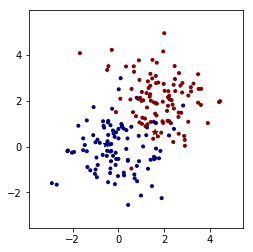

train labeled data


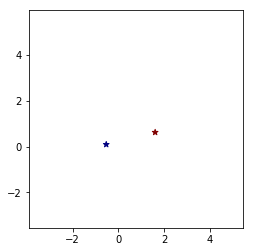

test all data


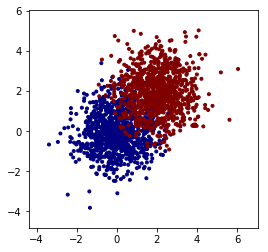

number of labeled train:  3
train all data


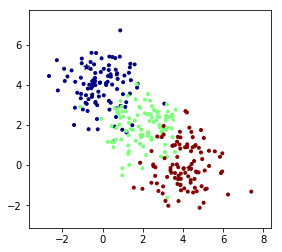

train labeled data


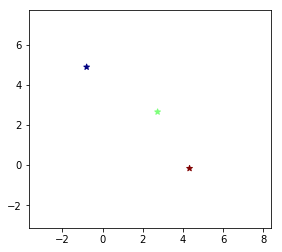

test all data


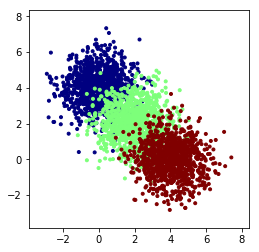

In [61]:
data = SimpleData()
data.visualize('train')
data.visualize_labeled_train()
data.visualize('test')
data = SimpleData(2, 3)
data.visualize('train')
data.visualize_labeled_train()
data.visualize('test')

In [62]:
class SimpleDataProvider(object):
    def __init__(self, data, batch_size):
        self.data = data
        self.batch_size = batch_size

    def get_next_batch_random(self, status='train', channel_idx=None, data_idx=None, estimate_label=None):
        if status == 'train':
            data = self.data.train_data
        else:
            data = self.data.test_data
        assert(data['x'].shape[0] == data['y'].shape[0])
        x = data['x']
        # If use estimate label instead of ground truth label
        if estimate_label is None:
            y = data['y']
        else:
            assert(data['y'].shape == estimate_label.shape)
            y = estimate_label
        # Check if only sample a subset of data, data_idx is a boolean array storing the sample or not flag
        if data_idx is not None:
            assert(data_idx.shape[0] == y.shape[0])
            x = x[data_idx, :]
            y = y[data_idx]
        # Make sure the final input and output are the same length
        assert(x.shape[0] == y.shape[0])
        # Sample a random batch
        idx = np.random.permutation(y.shape[0])
        idx = idx[0:self.batch_size]
        x = x[idx, :]
        y = y[idx]
        if channel_idx is not None:
            x = x[:, channel_idx]
        return x, y
    
    def get_next_batch_sequential(self, status='test', cnt=0, channel_idx=None, data_idx=None, estimate_label=None):
        if status == 'train':
            data = self.data.train_data
        else:
            data = self.data.test_data
        assert(data['x'].shape[0] == data['y'].shape[0])
        x = data['x']
        # If use estimate label instead of ground truth label
        if estimate_label is None:
            y = data['y']
        else:
            assert(data['y'].shape == estimate_label.shape)
            y = estimate_label
        # Check if only sample a subset of data, data_idx is a boolean array storing the sample or not flag
        if data_idx is not None:
            assert(data_idx.shape[0] == y.shape[0])
            x = x[data_idx, :]
            y = y[data_idx]
        # Make sure the final input and output are the same length
        assert(x.shape[0] == y.shape[0])
        # Sample a random batch and check if it is the end
        if cnt + self.batch_size > y.shape[0]:
            x = x[cnt:-1, :]
            y = y[cnt:-1]
            cnt = y.shape[0]
            end = True
        else:
            x = x[cnt:cnt + self.batch_size, :]
            y = y[cnt:cnt + self.batch_size]
            cnt = cnt + self.batch_size
            end = False
        if channel_idx is not None:
            x = x[:, channel_idx]
        return x, y, cnt, end

In [77]:
data = SimpleData()
data_provider = SimpleDataProvider(data, batch_size=16)
x, y = data_provider.get_next_batch_random('train')
x, y = data_provider.get_next_batch_random('test')
x, y, cnt, end = data_provider.get_next_batch_sequential('train', 0)
x, y, cnt, end = data_provider.get_next_batch_sequential('test', 0)
data_idx = np.ones(data_provider.data.test_data['y'].shape[0]).astype(np.bool)
data_idx[0] = 0
estimate_label = np.ones(data_provider.data.test_data['y'].shape[0]).astype(np.int)
print data_idx.shape, estimate_label.shape
x, y = data_provider.get_next_batch_random('test', None, data_idx, estimate_label)
print x.shape, y.shape
x, y, cnt, end = data_provider.get_next_batch_sequential('test', 0, None, data_idx, estimate_label)
print x.shape, y.shape, cnt, end
channel_idx = np.array([0, 1]).astype(np.bool)
x, y = data_provider.get_next_batch_random('test', None, data_idx, estimate_label)
print x.shape, y.shape
x, y, cnt, end = data_provider.get_next_batch_sequential('test', 0, channel_idx, data_idx, estimate_label)
print x.shape, y.shape, cnt, end

number of labeled train:  2
(2000,) (2000,)
(16, 2) (16,)
(16, 2) (16,) 16 False
(16, 2) (16,)
(16, 1) (16,) 16 False


In [73]:
class Interface(object):
    def __init__(self, model, data_provider, learning_rate=0.001, train_iter=1500, test_iter=10, test_interval=1501,
                 save_interval=1500, init_model_path='', save_model_path=''):
        self.model = model
        self.data_provider = data_provider
        self.learning_rate = learning_rate
        self.train_iter = train_iter
        self.test_iter = test_iter
        self.test_interval = test_interval
        self.save_interval = save_interval
        self.init_model_path = init_model_path
        self.save_model_path = save_model_path
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.init_model()
    
    def init_model(self):
        # model = torch.nn.DataParallel(model).cuda()
        self.model = self.model.to(self.device)
        if self.init_model_path is not '':
            self.model.load_state_dict(torch.load(self.init_model_path))
        
    def train(self, channel_idx=None, data_idx=None, estimate_label=None):
        self.model.train()
        torch.set_grad_enabled(True)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_loss_all, train_acc_all = [], []
        for it in range(self.train_iter):
            x, y = self.data_provider.get_next_batch_random('train', channel_idx, data_idx, estimate_label)
            x = torch.from_numpy(x).float().to(self.device)
            y = torch.from_numpy(y).long().to(self.device)
            
            optimizer.zero_grad()
            pred = self.model(x)
            loss = criterion(pred, y)
            loss.backward()
            optimizer.step()

            _, pred_label = torch.max(pred, 1)
            acc = (pred_label == y).sum().float() / y.size(0)
            
            train_loss_all.append(loss)
            if len(train_loss_all) > 100:
                train_loss_all.pop(0)
            ave_train_loss = sum(train_loss_all) / float(len(train_loss_all))
            if (it+1) % 100 == 0:
                print('iteration %d, train loss: %.2f, average train loss: %.2f' % (it, loss, ave_train_loss))
            train_acc_all.append(acc)
            if len(train_acc_all) > 100:
                train_acc_all.pop(0)
            ave_train_acc = sum(train_acc_all) / float(len(train_acc_all))
            if (it+1) % 100 == 0:
                print('iteration %d, train accuracy: %.2f, average train accuracy: %.2f' % (it, acc, ave_train_acc))
            if (it+1) % self.test_interval == 0:
                print('iteration %d, testing' % it)
                self.test(channel_idx)
                self.model.train()
                torch.set_grad_enabled(True)
            if (it+1) % self.save_interval == 0:
                if self.save_model_path is not '':
                    print('iteration %d, saving model to %s' % (it, self.save_model_path))
                    with open(self.save_model_path, 'w') as handle:
                        torch.save(self.model.state_dict(), handle)
    
    def test(self, channel_idx=None):
        self.model.eval()
        torch.set_grad_enabled(False)
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        for it in range(self.test_iter):
            x, y = self.data_provider.get_next_batch_random('test', channel_idx)
            x = torch.from_numpy(x).float().to(self.device)
            y = torch.from_numpy(y).long().to(self.device)

            pred = self.model(x)
            loss = criterion(pred, y)
            _, pred_label = torch.max(pred, 1)
            acc = (pred_label == y).sum().float() / y.size(0)

            test_loss_all.append(loss)
            if len(test_loss_all) > 100:
                test_loss_all.pop(0)
            test_acc_all.append(acc)
            if len(test_acc_all) > 100:
                test_acc_all.pop(0)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        print('average test loss: %.2f, average test accuracy: %.2f' % (test_loss, test_acc))
    
    def test_all(self, channel_idx=None):
        self.model.eval()
        torch.set_grad_enabled(False)
        test_loss_all, test_acc_all = [], []
        criterion = nn.CrossEntropyLoss()
        cnt = 0
        while True:
            x, y, cnt, end = self.data_provider.get_next_batch_sequential('test', cnt, channel_idx)
            if end:
                break
            x = torch.from_numpy(x).float().to(self.device)
            y = torch.from_numpy(y).long().to(self.device)

            pred = self.model(x)
            loss = criterion(pred, y)
            _, pred_label = torch.max(pred, 1)
            acc = (pred_label == y).sum().float() / y.size(0)
            
            test_loss_all.append(loss)
            if len(test_loss_all) > 100:
                test_loss_all.pop(0)
            test_acc_all.append(acc)
            if len(test_acc_all) > 100:
                test_acc_all.pop(0)

        test_loss = np.mean(np.array(test_loss_all))
        test_acc = np.mean(np.array(test_acc_all))
        print('overall test loss: %.2f, overall test accuracy: %.2f' % (test_loss, test_acc))
    
    def predict(self, x, channel_idx=None):
        self.model.eval()
        torch.set_grad_enabled(False)
        if channel_idx is not None:
            x = x[:, channel_idx]
        x = torch.from_numpy(x).float().to(self.device)
        pred = self.model(x)
        pred = F.softmax(pred, 1)
        pred = pred.cpu().numpy()
        return pred
    
    def visualize(self, status='train', channel_idx=None, data_idx=None):
        if status == 'train':
            data = self.data_provider.data.train_data
        else:
            data = self.data_provider.data.test_data
        x_min, x_max = data['x'][:, 0].min() - 1, data['x'][:, 0].max() + 1
        y_min, y_max = data['x'][:, 1].min() - 1, data['x'][:, 1].max() + 1
        x_interval = (x_max - x_min) / 100.0
        y_interval = (y_max - y_min) / 100.0
        xx, yy = np.meshgrid(np.arange(x_min, x_max, x_interval), np.arange(y_min, y_max, y_interval))
        x = np.c_[xx.ravel(), yy.ravel()]
        pred = self.predict(x, channel_idx)
        y = np.argmax(pred, 1)
        y = y.reshape(xx.shape)
        print status, 'with decision boundary'
        plt.subplots(1)
        plt.contourf(xx, yy, y, cmap=plt.cm.jet)
        if data_idx is None:
            plt.scatter(data['x'][:, 0], data['x'][:, 1], c=data['y'], cmap=plt.cm.jet)
        else:
            plt.scatter(data['x'][data_idx, 0], data['x'][data_idx, 1], c=data['y'][data_idx], cmap=plt.cm.jet)
        plt.axis('scaled')
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        plt.axis('off')
        plt.show()

In [74]:
class SimpleNet(nn.Module):
    def __init__(self, n_input, n_output):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(n_input, n_output)
        
    def forward(self, x):
        y = self.fc(x)
        return y

iteration 99, train loss: 1.01, average train loss: 1.10
iteration 99, train accuracy: 0.06, average train accuracy: 0.10
iteration 199, train loss: 0.82, average train loss: 0.90
iteration 199, train accuracy: 0.56, average train accuracy: 0.34
iteration 299, train loss: 0.69, average train loss: 0.75
iteration 299, train accuracy: 0.50, average train accuracy: 0.49
iteration 399, train loss: 0.59, average train loss: 0.64
iteration 399, train accuracy: 0.62, average train accuracy: 0.51
iteration 499, train loss: 0.52, average train loss: 0.56
iteration 499, train accuracy: 0.62, average train accuracy: 0.61
iteration 599, train loss: 0.50, average train loss: 0.48
iteration 599, train accuracy: 0.81, average train accuracy: 0.74
iteration 699, train loss: 0.49, average train loss: 0.43
iteration 699, train accuracy: 0.75, average train accuracy: 0.81
iteration 799, train loss: 0.44, average train loss: 0.40
iteration 799, train accuracy: 0.81, average train accuracy: 0.84
iteration 

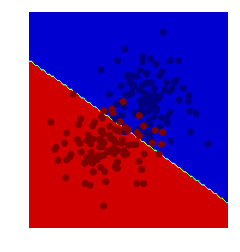

test with decision boundary


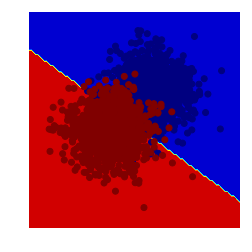

In [75]:
model = SimpleNet(2, 2)
interface = Interface(model, data_provider)
interface.train()
interface.test_all()
interface.visualize('train')
interface.visualize('test')

iteration 99, train loss: 0.69, average train loss: 0.72
iteration 99, train accuracy: 0.50, average train accuracy: 0.50
iteration 199, train loss: 0.66, average train loss: 0.67
iteration 199, train accuracy: 0.50, average train accuracy: 0.50
iteration 299, train loss: 0.62, average train loss: 0.64
iteration 299, train accuracy: 0.50, average train accuracy: 0.50
iteration 399, train loss: 0.59, average train loss: 0.61
iteration 399, train accuracy: 0.50, average train accuracy: 0.50
iteration 499, train loss: 0.56, average train loss: 0.57
iteration 499, train accuracy: 0.50, average train accuracy: 0.50
iteration 599, train loss: 0.52, average train loss: 0.54
iteration 599, train accuracy: 0.50, average train accuracy: 0.50
iteration 699, train loss: 0.49, average train loss: 0.51
iteration 699, train accuracy: 0.50, average train accuracy: 0.50
iteration 799, train loss: 0.47, average train loss: 0.48
iteration 799, train accuracy: 0.50, average train accuracy: 0.50
iteration 

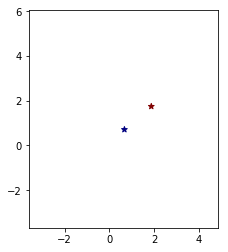

train with decision boundary


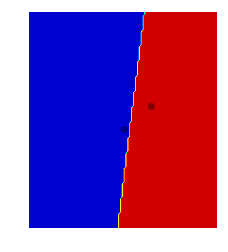

test with decision boundary


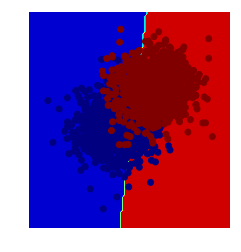

In [78]:
model = SimpleNet(2, 2)
interface = Interface(model, data_provider)
interface.train(channel_idx=None, data_idx=data_provider.data.train_data['labeled'])
interface.test_all()
interface.data_provider.data.visualize_labeled_train()
interface.visualize('train', channel_idx=None, data_idx=data_provider.data.train_data['labeled'])
interface.visualize('test')

In [79]:
class CoTrainDataPool(object):
    def __init__(self, channel_idx, label_data_idx, y):
        self.channel_idx = channel_idx
        self.label_data_idx = label_data_idx
        self.estimate_label = y
        self.label_data_index = np.nonzero(self.label_data_idx)[0]
    
    def add_data(self, idx, y):
        self.label_data_idx = np.logical_or(self.label_data_idx, idx)
        self.estimate_label[idx] = y[idx]
        self.label_data_index = np.nonzero(self.label_data_idx)[0]

In [80]:
class CoTrainInterface(object):
    def __init__(self, model, data_provider, channel_idx, init_model_path, save_model_path, 
                 learning_rate=0.001, train_iter=1500, test_iter=10, test_interval=1501, save_interval=1500):
        self.interface = []
        for i in range(len(model)):
            interface = Interface(model[i], data_provider, learning_rate, train_iter, test_iter, test_interval, 
                                  save_interval, init_model_path[i], save_model_path[i])
            self.interface.append(interface)
        self.train_data_pool = []
        for i in range(len(model)):
            data_idx = self.interface[i].data_provider.data.train_data['labeled']
            y = self.interface[i].data_provider.data.train_data['y']
            train_data_pool = CoTrainDataPool(channel_idx[i, :], data_idx, y)
            self.train_data_pool.append(train_data_pool)

    def init_train(self):
        for i in range(len(self.interface)):
            pool = self.train_data_pool[i]
            self.interface[i].train(pool.channel_idx, pool.label_data_idx, pool.estimate_label)

    def co_train(self):
        # Predict using current models
        pred_prob = []
        for i in range(len(self.interface)):
            pool = self.train_data_pool[i]
            x = self.interface[i].data_provider.data.train_data['x'][:, pool.channel_idx]
            pred = self.interface[i].predict(x)
            pred_prob.append(pred)
        # Select high confidence estimated labels and add them into the training pool
        for i in range(len(self.interface)):
            pool = self.train_data_pool[i]
            high_conf_idx, estimate_label = self.obtain_high_confidence(pred_prob, i, pool.label_data_index)
            self.train_data_pool[i].add_data(high_conf_idx, estimate_label)
            print 'pool', i, 'number of train:', np.sum(self.train_data_pool[i].label_data_idx)
        # Retrain each model
        for i in range(len(self.interface)):
            pool = self.train_data_pool[i]
            self.interface[i].train(pool.channel_idx, pool.label_data_idx, pool.estimate_label)

    def obtain_high_confidence(self, pred_prob, exclude_idx, label_data_index):
        pred_prob = pred_prob[:exclude_idx] + pred_prob[exclude_idx+1:]
        cumulate_prob = pred_prob[0]
        for i in range(len(pred_prob) - 1):
            cumulate_prob = cumulate_prob * pred_prob[i + 1]
            cumulate_prob = cumulate_prob / np.sum(cumulate_prob, 1)
        estimate_label = np.argmax(cumulate_prob, 1)
        max_prob = np.max(cumulate_prob, 1)
        idx = np.argsort(max_prob)[::-1]
        print label_data_index
        label_data_index = set(label_data_index)
        idx = [i for i in idx if i not in label_data_index]
        idx = idx[:5]
        print max_prob[idx]
        print idx
        high_conf_idx = np.zeros(cumulate_prob.shape[0]).astype(np.bool)
        high_conf_idx[idx] = True
        return high_conf_idx, estimate_label
    
    def test(self):
        for i in range(len(self.interface)):
            pool = self.train_data_pool[i]
            self.interface[i].test_all(pool.channel_idx)
    
    def combine_train_data_pool(self):
        channel_idx = np.ones(self.train_data_pool[0].channel_idx.shape[0])
        label_data_idx = np.zeros(self.train_data_pool[0].label_data_idx.shape[0])
        estimate_label = np.zeros(self.train_data_pool[0].estimate_label.shape[0])
        final_train_data_pool = CoTrainDataPool(channel_idx, label_data_idx, estimate_label)
        for i in range(len(self.train_data_pool)):
            pool = self.train_data_pool[i]
            final_train_data_pool.add_data(pool.label_data_idx, pool.estimate_label)
        return final_train_data_pool
    
    def visualize_labeled_train(self):
        for i in range(len(self.interface)):
            pool = self.train_data_pool[i]
            self.interface[i].data_provider.data.visualize_labeled_train(pool.label_data_idx)
            self.interface[i].visualize('train', pool.channel_idx, pool.label_data_idx)

    def visualize(self, status):
        for i in range(len(self.interface)):
            pool = self.train_data_pool[i]
            self.interface[i].visualize(status, pool.channel_idx)

iteration 99, train loss: 0.46, average train loss: 0.49
iteration 99, train accuracy: 1.00, average train accuracy: 1.00
iteration 199, train loss: 0.43, average train loss: 0.44
iteration 199, train accuracy: 1.00, average train accuracy: 1.00
iteration 299, train loss: 0.40, average train loss: 0.41
iteration 299, train accuracy: 1.00, average train accuracy: 1.00
iteration 399, train loss: 0.37, average train loss: 0.39
iteration 399, train accuracy: 1.00, average train accuracy: 1.00
iteration 499, train loss: 0.35, average train loss: 0.36
iteration 499, train accuracy: 1.00, average train accuracy: 1.00
iteration 599, train loss: 0.32, average train loss: 0.33
iteration 599, train accuracy: 1.00, average train accuracy: 1.00
iteration 699, train loss: 0.30, average train loss: 0.31
iteration 699, train accuracy: 1.00, average train accuracy: 1.00
iteration 799, train loss: 0.28, average train loss: 0.29
iteration 799, train accuracy: 1.00, average train accuracy: 1.00
iteration 

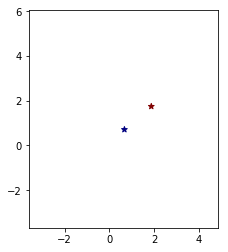

train with decision boundary


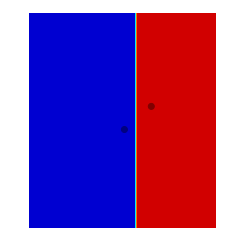

train labeled data


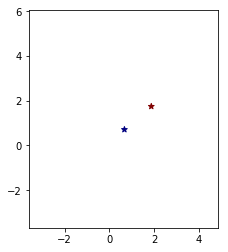

train with decision boundary


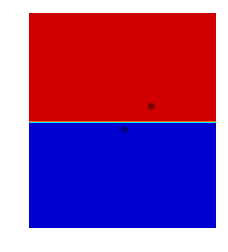

[  0 100]
[0.9998547  0.99970007 0.9996414  0.9993728  0.9973156 ]
[157, 40, 145, 164, 93]
pool 0 number of train: 7
[  0 100]
[0.9999783  0.99968994 0.9995653  0.99948406 0.99940693]
[42, 21, 41, 84, 148]
pool 1 number of train: 7
iteration 99, train loss: 0.31, average train loss: 0.32
iteration 99, train accuracy: 0.86, average train accuracy: 0.86
iteration 199, train loss: 0.29, average train loss: 0.30
iteration 199, train accuracy: 0.86, average train accuracy: 0.86
iteration 299, train loss: 0.28, average train loss: 0.29
iteration 299, train accuracy: 0.86, average train accuracy: 0.86
iteration 399, train loss: 0.28, average train loss: 0.28
iteration 399, train accuracy: 0.86, average train accuracy: 0.86
iteration 499, train loss: 0.28, average train loss: 0.28
iteration 499, train accuracy: 0.86, average train accuracy: 0.86
iteration 599, train loss: 0.28, average train loss: 0.28
iteration 599, train accuracy: 0.86, average train accuracy: 0.86
iteration 699, train loss:

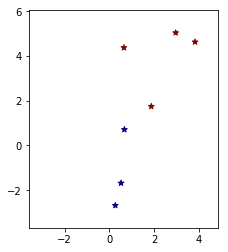

train with decision boundary


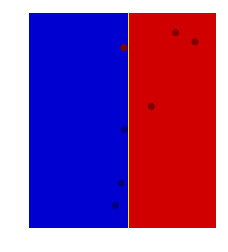

train labeled data


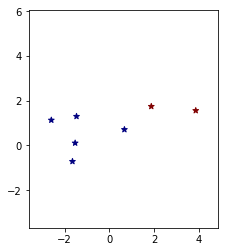

train with decision boundary


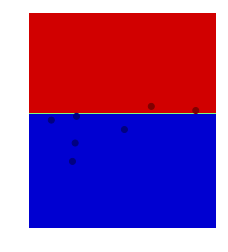

[  0  40  93 100 145 157 164]
[0.99976784 0.9997664  0.99968135 0.9996301  0.9994825 ]
[55, 94, 60, 36, 25]
pool 0 number of train: 12
[  0  21  41  42  84 100 148]
[0.9999963  0.9999957  0.99998534 0.99998105 0.99998045]
[145, 130, 162, 124, 189]
pool 1 number of train: 12
iteration 99, train loss: 0.22, average train loss: 0.22
iteration 99, train accuracy: 0.92, average train accuracy: 0.87
iteration 199, train loss: 0.21, average train loss: 0.22
iteration 199, train accuracy: 0.92, average train accuracy: 0.92
iteration 299, train loss: 0.21, average train loss: 0.21
iteration 299, train accuracy: 0.92, average train accuracy: 0.92
iteration 399, train loss: 0.21, average train loss: 0.21
iteration 399, train accuracy: 0.92, average train accuracy: 0.92
iteration 499, train loss: 0.21, average train loss: 0.21
iteration 499, train accuracy: 0.92, average train accuracy: 0.92
iteration 599, train loss: 0.21, average train loss: 0.21
iteration 599, train accuracy: 0.92, average trai

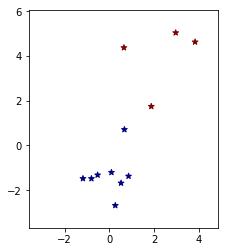

train with decision boundary


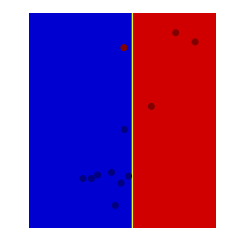

train labeled data


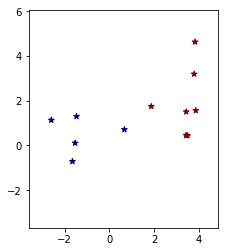

train with decision boundary


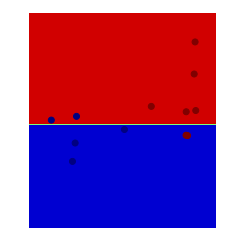

In [81]:
num_class = data_provider.data.num_class
num_dim = data_provider.data.num_dim
model = [SimpleNet(1, num_class) for i in range(num_dim)]
channel_idx = np.identity(num_dim).astype(np.bool)
init_model_path = ['' for i in range(num_dim)]
save_model_path = ['./model_%d.pth' % i for i in range(num_dim)]
co_interface = CoTrainInterface(model, data_provider, channel_idx, init_model_path, save_model_path)
co_interface.init_train()
co_interface.test()
co_interface.visualize_labeled_train()
co_interface.co_train()
co_interface.test()
co_interface.visualize_labeled_train()
co_interface.co_train()
co_interface.test()
co_interface.visualize_labeled_train()

iteration 99, train loss: 0.89, average train loss: 0.91
iteration 99, train accuracy: 0.56, average train accuracy: 0.57
iteration 199, train loss: 0.71, average train loss: 0.72
iteration 199, train accuracy: 0.75, average train accuracy: 0.63
iteration 299, train loss: 0.62, average train loss: 0.60
iteration 299, train accuracy: 0.69, average train accuracy: 0.71
iteration 399, train loss: 0.43, average train loss: 0.50
iteration 399, train accuracy: 0.75, average train accuracy: 0.71
iteration 499, train loss: 0.41, average train loss: 0.39
iteration 499, train accuracy: 0.75, average train accuracy: 0.74
iteration 599, train loss: 0.26, average train loss: 0.32
iteration 599, train accuracy: 0.88, average train accuracy: 0.85
iteration 699, train loss: 0.18, average train loss: 0.27
iteration 699, train accuracy: 0.88, average train accuracy: 0.86
iteration 799, train loss: 0.17, average train loss: 0.22
iteration 799, train accuracy: 0.94, average train accuracy: 0.87
iteration 

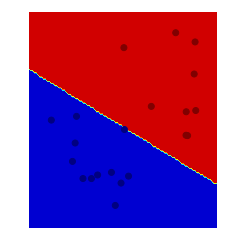

test with decision boundary


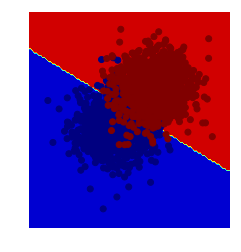

In [82]:
pool = co_interface.combine_train_data_pool()
model = SimpleNet(2, 2)
final_interface = Interface(model, data_provider)
final_interface.train(None, pool.label_data_idx, pool.estimate_label)
final_interface.test_all()
final_interface.visualize('train', None, pool.label_data_idx)
final_interface.visualize('test')